# Load Data

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import DC_Pickle as dcp
import Curve_Functions as cv
import matplotlib.pyplot as plt
%matplotlib inline

def disp_Data(x, y_true, y_pred, file_path, clt_num, cost, rows=1, columns=1, size=(6, 4)):
    fig, ax = plt.subplots(rows, columns, figsize=size)
    ax.plot(x, y_true, 'rx', label='average score')
    ax.plot(x, y_pred, 'b-', label='curve fitting')
    ax.set_xlim([0, max(x)+1])
    ax.set_ylim([0, max(y_true)+0.2])
    ax.legend(fontsize=14)
    ax.set_title("cluster {0}: cost {1}".format(clt_num, round(cost, 2)))
    fig.savefig(file_path, dpi=100)
    plt.show()
    
train_idx = dcp.open_Pickle("../../data/pickles/clusters_origin/indices/index13.pickle")
train_idx = train_idx[9] #2, 8

train_scores = dcp.open_Pickle('../../data/pickles/seperate_origin/eventValue.pickle')
train_scores = train_scores[:300, :]/1e+4
attempts15 = np.arange(15)+1
attempts300 = np.arange(300)+1

## filtering discontinuous under 15 attempts
idx_all = []
idx_pure = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:15, i]).any():
        idx_all.append(i)
        idx_pure.append(i)
    else:
        idx_all.append(np.nan)

train_scores = train_scores[:, idx_pure]
print("Training data set: {0}".format(np.shape(train_scores)))

## get cluster data and cluster average data (average is centroid)
nClt = 13
for i in range(nClt):
    name = "cluster{0}".format(i+1)
    globals()[name] = train_scores[:, train_idx==i] # get cluster data
    
    ## get cluster average data
    data = np.ones(300)
    for j in range(len(data)):
        avg = eval(name)[j, :]
        avg = np.sum(avg[~np.isnan(avg)])/len(avg[~np.isnan(avg)])
        data[j] = avg

    globals()["avg{0}".format(i+1)] = data
    
dcp.make_folders("../../Figs/curve_fitting/")

Training data set: (300, 22832)
../../Figs/curve_fitting/ already present - Skipping pickling.


# 1. Single Curve
## 1-1. Two parameters

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential2/single/")

seed = [1, 1]
for i in range(nClt):
    print("cluster {0}:".format(i+1))
    ## train
    exp2_opt, exp2_cost = cv.curve_Fitting(
        cv.exponential_least2, cv.exponential_curve2, 
        attempts15, eval("avg{0}".format(i+1))[:15], seed, 
        "../../Figs/curve_fitting/exponential2/single/{0}".format(i+1), clt_num = i+1)
    ## validation
    y_fit = cv.exponential_curve2(attempts300, exp2_opt[0], exp2_opt[1])
    
    exp2_cost300 = cv.cost_Function(eval("avg{0}".format(i+1)), y_fit) # get cost for all data
    
    disp_Data(attempts300, eval("avg{0}".format(i+1)), y_fit, 
              file_path="../../Figs/curve_fitting/exponential2/single/valid{0}".format(i+1), 
              clt_num=i+1, cost = exp2_cost300)

## 1-2. Three parameters

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential3/single/")

seed = [1, 1, 1]
for i in range(nClt):
    print("cluster {0}:".format(i+1))
    exp3_opt, exp3_cost = cv.curve_Fitting(
        cv.exponential_least3, cv.exponential_curve3, 
        attempts15, eval("avg{0}".format(i+1))[:15], seed,
        "../../Figs/curve_fitting/exponential3/single/{0}".format(i+1), clt_num = i+1)

    y_fit = cv.exponential_curve3(attempts300, exp3_opt[0], exp3_opt[1], exp3_opt[2])
    exp3_cost300 = cv.cost_Function(eval("avg{0}".format(i+1)), y_fit) # get cost for all data
    
    cost300 = cv.cost_Function(attempts300, y_fit)
    disp_Data(attempts300, eval("avg{0}".format(i+1)), y_fit, 
              file_path="../../Figs/curve_fitting/exponential3/single/valid{0}".format(i+1), 
              clt_num=i+1, cost = exp3_cost300)

# 2. Multiple Curves
## 2-1. Two parameters
#### 1) two curves

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential2/two/")

seed = [1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    exp2_p1 = cv.multi_curveFitting_2(cv.exponential_least2, eval("avg{0}".format(i+1)), seed, min_range=15)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:exp2_p1]
    x2 = x_range[exp2_p1:]

    true_y1 = eval("avg{0}".format(i+1))[:exp2_p1]
    true_y2 = eval("avg{0}".format(i+1))[exp2_p1:]

    lsq1 = least_squares(cv.exponential_least2, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least2, seed, args=(x2, true_y2))

    pred_y1 = cv.exponential_curve2(x_range[:exp2_p1], lsq1.x[0], lsq1.x[1])
    pred_y2 = cv.exponential_curve2(x_range, lsq2.x[0], lsq2.x[1])

    print(" - break point: {0}".format(exp2_p1))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:exp2_p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range, pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(np.ones(100)*exp2_p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.set_title("Cluster {0} (Cost {1}), Break point{2}"
                 .format(i, round(lsq1.cost+lsq2.cost, 2), exp2_p1) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential2/two/cluster{0}".format(i+1), dpi=100)
    # plt.show()

#### 2) three curves

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential2/three/")

seed = [1, 1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    exp2_p1, exp2_p2 = cv.multi_curveFitting_3(cv.exponential_least2, eval("avg{0}".format(i+1)), seed, min_range=15)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:exp2_p1]
    x2 = x_range[exp2_p1:exp2_p2]
    x3 = x_range[exp2_p2:]

    true_y1 = eval("avg{0}".format(i+1))[:exp2_p1]
    true_y2 = eval("avg{0}".format(i+1))[exp2_p1:exp2_p2]
    true_y3 = eval("avg{0}".format(i+1))[exp2_p2:]

    lsq1 = least_squares(cv.exponential_least2, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least2, seed, args=(x2, true_y2))
    lsq3 = least_squares(cv.exponential_least2, seed, args=(x3, true_y3))

    pred_y1 = cv.exponential_curve2(x_range[:exp2_p1], lsq1.x[0], lsq1.x[1])
    pred_y2 = cv.exponential_curve2(x_range[:exp2_p2], lsq2.x[0], lsq2.x[1])
    pred_y3 = cv.exponential_curve2(x_range, lsq3.x[0], lsq3.x[1])

    print(" - break point: {0} and {1}".format(exp2_p1, exp2_p2))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:exp2_p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range[:exp2_p2], pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(x_range, pred_y3, 'c-', label='curve 2', linewidth=3)
    
    # break points
    ax.plot(np.ones(100)*exp2_p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.plot(np.ones(100)*exp2_p2, np.linspace(0, 10, 100), '-.k', linewidth=1)
    
    ax.set_title("Cluster {0} (Cost {1}), Break point:{2} and {3}"
                 .format(i, round(lsq1.cost+lsq2.cost+lsq3.cost, 2), exp2_p1, exp2_p2) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential2/three/cluster{0}".format(i+1), dpi=100)
    # plt.show()

## 2-2. Three parameters
#### 1) two curves

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential3/two/")

seed = [1, 1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    exp3_p1 = cv.multi_curveFitting_2(cv.exponential_least3, eval("avg{0}".format(i+1)), seed, min_range=15)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:exp3_p1]
    x2 = x_range[exp3_p1:]

    true_y1 = eval("avg{0}".format(i+1))[:exp3_p1]
    true_y2 = eval("avg{0}".format(i+1))[exp3_p1:]

    lsq1 = least_squares(cv.exponential_least3, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least3, seed, args=(x2, true_y2))

    pred_y1 = cv.exponential_curve3(x_range[:exp3_p1], lsq1.x[0], lsq1.x[1], lsq1.x[2])
    pred_y2 = cv.exponential_curve3(x_range, lsq2.x[0], lsq2.x[1], lsq2.x[2])

    print(" - break point: {0}".format(exp3_p1))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:exp3_p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range, pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(np.ones(100)*exp3_p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.set_title("Cluster {0} (Cost {1}), Break point{2}"
                 .format(i, round(lsq1.cost+lsq2.cost, 2), exp3_p1) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential3/two/cluster{0}".format(i+1), dpi=100)
    # plt.show()

#### 2) three curves

In [ ]:
dcp.make_folders("../../Figs/curve_fitting/exponential3/three/")

seed = [1, 1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    exp3_p1, exp3_p2 = cv.multi_curveFitting_3(cv.exponential_least3, eval("avg{0}".format(i+1)), seed, min_range=15)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:exp3_p1]
    x2 = x_range[exp3_p1:exp3_p2]
    x3 = x_range[exp3_p2:]

    true_y1 = eval("avg{0}".format(i+1))[:exp3_p1]
    true_y2 = eval("avg{0}".format(i+1))[exp3_p1:exp3_p2]
    true_y3 = eval("avg{0}".format(i+1))[exp3_p2:]

    lsq1 = least_squares(cv.exponential_least3, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least3, seed, args=(x2, true_y2))
    lsq3 = least_squares(cv.exponential_least3, seed, args=(x3, true_y3))

    pred_y1 = cv.exponential_curve3(x_range[:exp3_p1], lsq1.x[0], lsq1.x[1], lsq1.x[2])
    pred_y2 = cv.exponential_curve3(x_range[:exp3_p2], lsq2.x[0], lsq2.x[1], lsq2.x[2])
    pred_y3 = cv.exponential_curve3(x_range, lsq3.x[0], lsq3.x[1], lsq3.x[2])

    print(" - break point: {0} and {1}".format(exp3_p1, exp3_p2))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:exp3_p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range[:exp3_p2], pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(x_range, pred_y3, 'c-', label='curve 2', linewidth=3)
    
    # break points
    ax.plot(np.ones(100)*exp3_p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.plot(np.ones(100)*exp3_p2, np.linspace(0, 10, 100), '-.k', linewidth=1)
    
    ax.set_title("Cluster {0} (Cost {1}), Break point:{2} and {3}"
                 .format(i, round(lsq1.cost+lsq2.cost+lsq3.cost, 2), exp3_p1, exp3_p2) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential3/three/cluster{0}".format(i+1), dpi=100)
    # plt.show()

## 2-2. Four parameters
#### 1) two curves

../../Figs/curve_fitting/exponential4/two/ already present - Skipping pickling.
cluster 1:
 - break point: 250
cluster 2:
 - break point: 250
cluster 3:
 - break point: 250
cluster 4:
 - break point: 250
cluster 5:
 - break point: 50
cluster 6:
 - break point: 250
cluster 7:
 - break point: 50
cluster 8:
 - break point: 50
cluster 9:
 - break point: 200
cluster 10:
 - break point: 250
cluster 11:
 - break point: 50
cluster 12:
 - break point: 200
cluster 13:
 - break point: 150


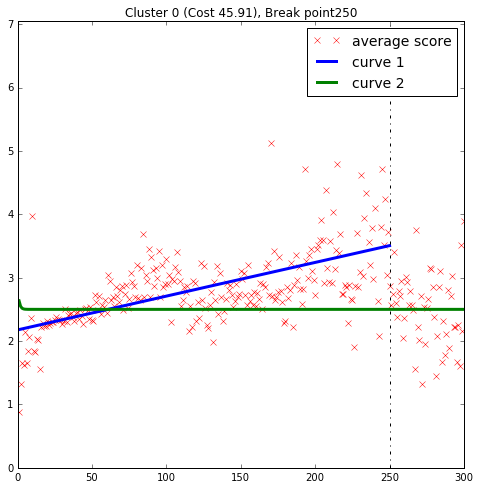

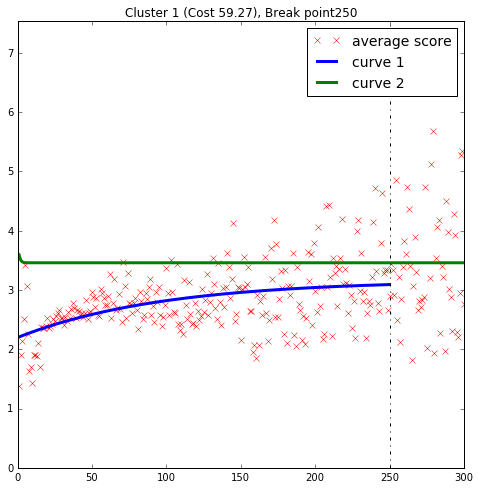

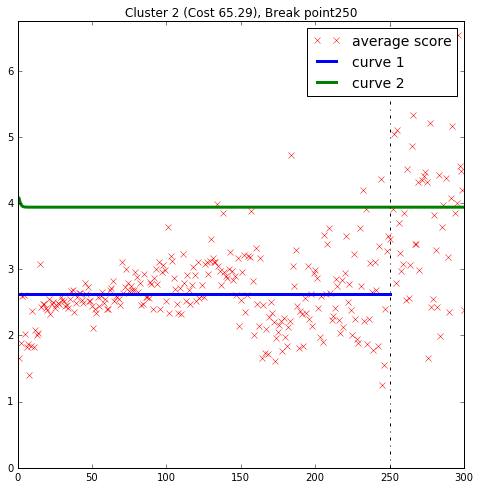

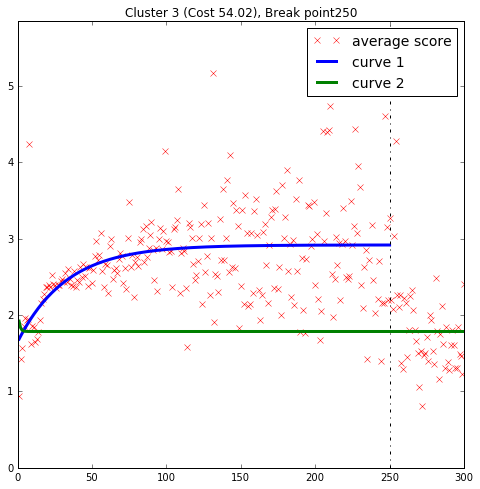

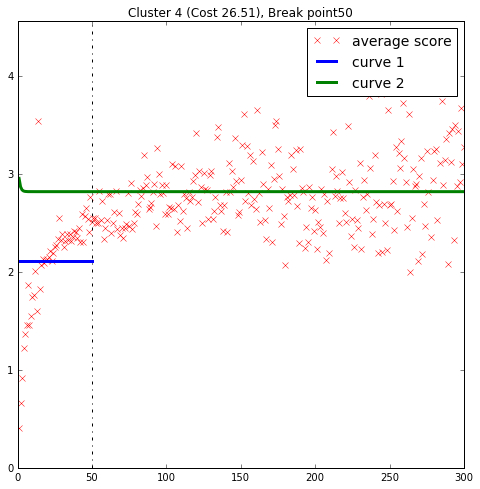

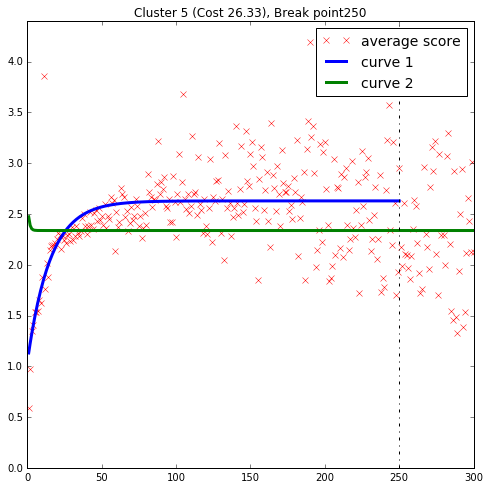

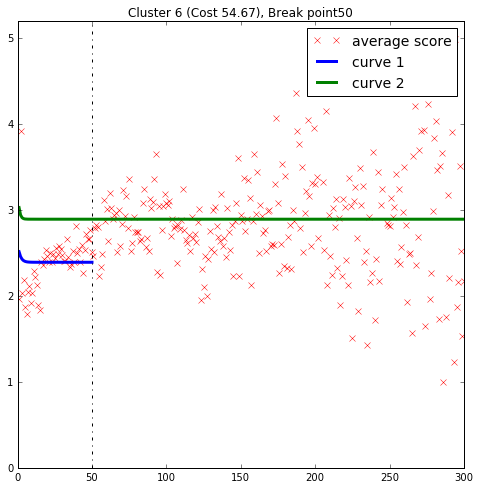

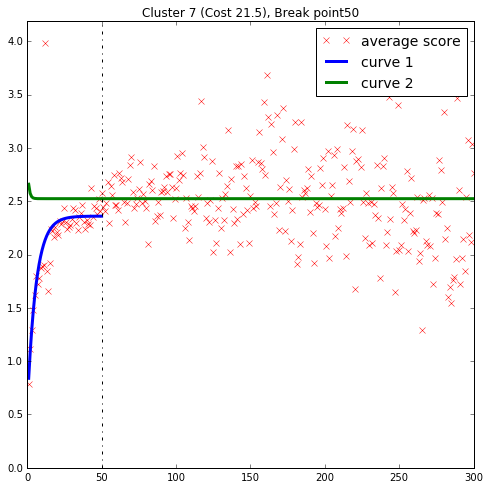

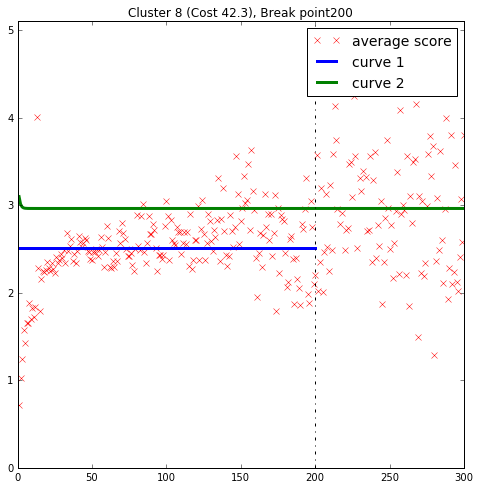

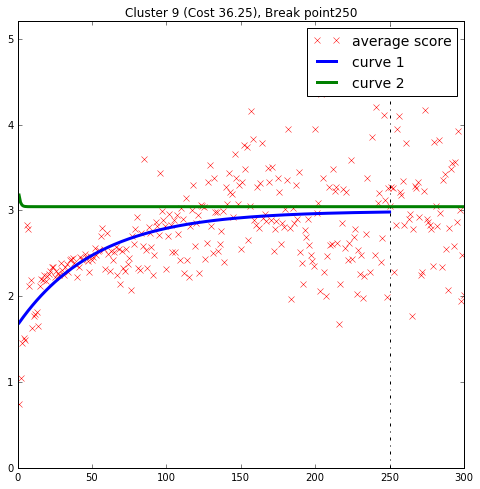

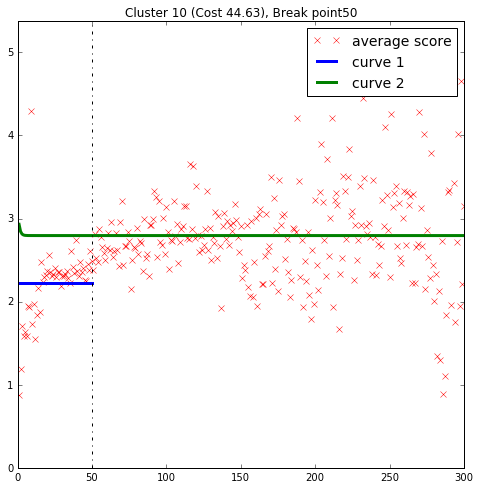

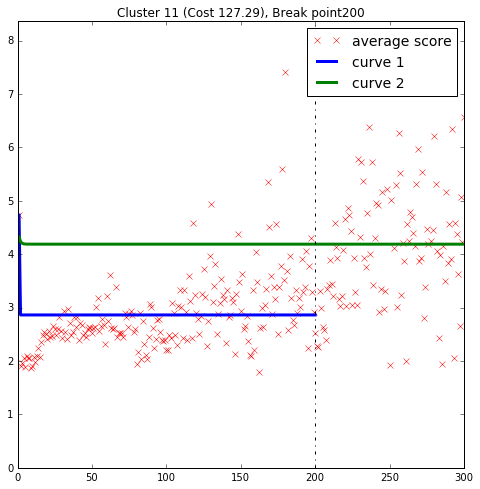

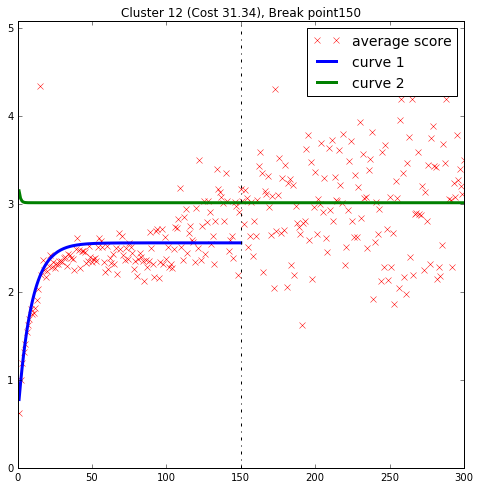

In [2]:
dcp.make_folders("../../Figs/curve_fitting/exponential4/two/")

seed = [1, 1, 1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    p1 = cv.multi_curveFitting_2(cv.exponential_least4, eval("avg{0}".format(i+1)), seed, min_range=50)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:p1]
    x2 = x_range[p1:]

    true_y1 = eval("avg{0}".format(i+1))[:p1]
    true_y2 = eval("avg{0}".format(i+1))[p1:]

    lsq1 = least_squares(cv.exponential_least4, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least4, seed, args=(x2, true_y2))

    pred_y1 = cv.exponential_curve4(x_range[:p1], lsq1.x[0], lsq1.x[1], lsq1.x[2], lsq1.x[3])
    pred_y2 = cv.exponential_curve4(x_range, lsq2.x[0], lsq2.x[1], lsq2.x[2], lsq2.x[3])

    print(" - break point: {0}".format(p1))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range, pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(np.ones(100)*p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.set_title("Cluster {0} (Cost {1}), Break point{2}"
                 .format(i, round(lsq1.cost+lsq2.cost, 2), p1) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential4/two/cluster{0}".format(i+1), dpi=100)
    # plt.show()

#### 2) three curves

../../Figs/curve_fitting/exponential4/three/ already present - Skipping pickling.
cluster 1:
 - break point: 200
cluster 2:
 - break point: 200
cluster 3:
 - break point: 200
cluster 4:
 - break point: 200
cluster 5:
 - break point: 50
cluster 6:
 - break point: 100
cluster 7:
 - break point: 50
cluster 8:
 - break point: 50
cluster 9:
 - break point: 50
cluster 10:
 - break point: 50
cluster 11:
 - break point: 50
cluster 12:
 - break point: 150
cluster 13:
 - break point: 150


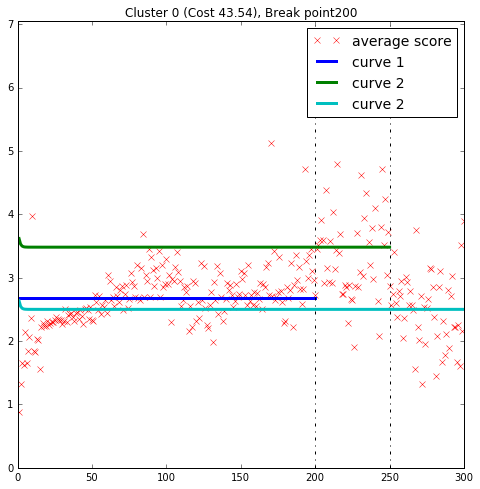

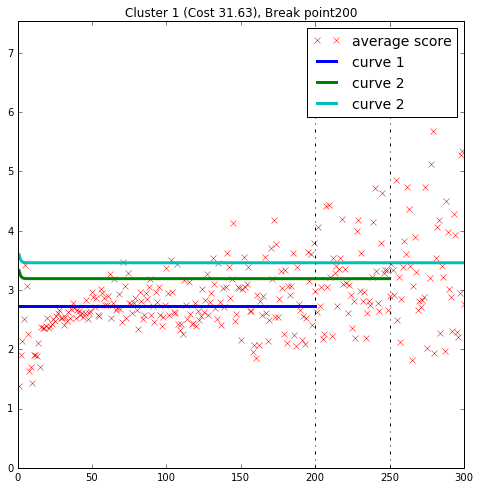

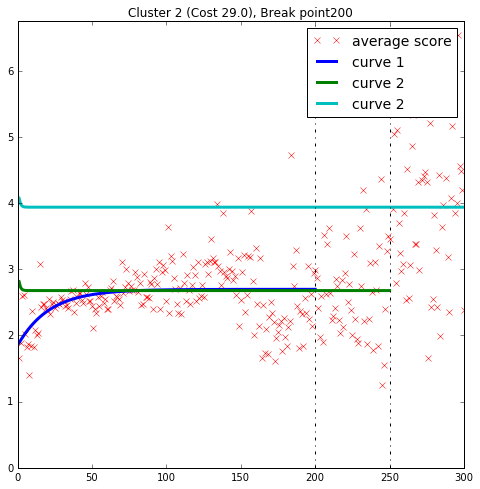

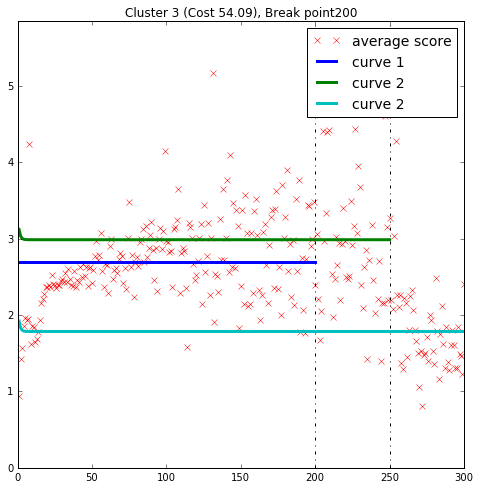

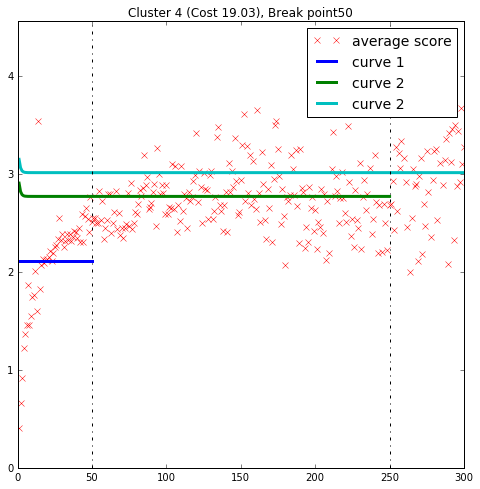

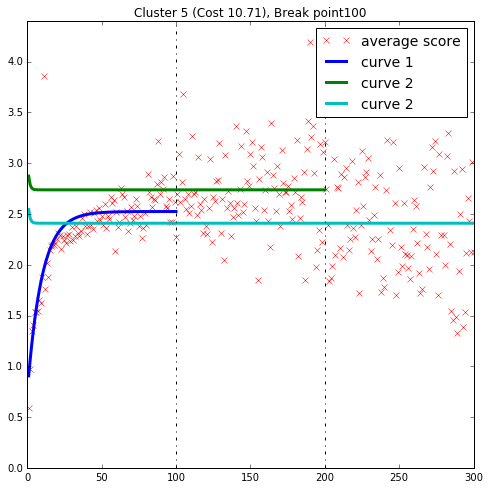

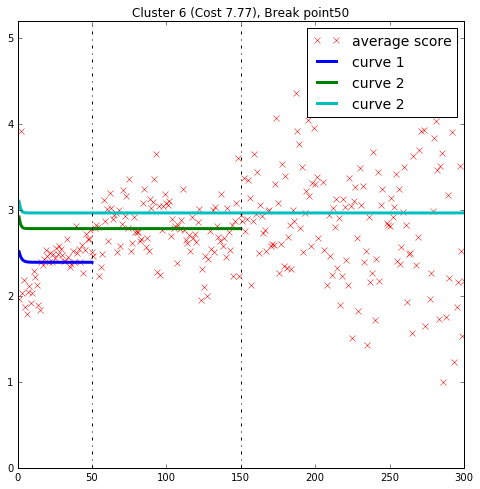

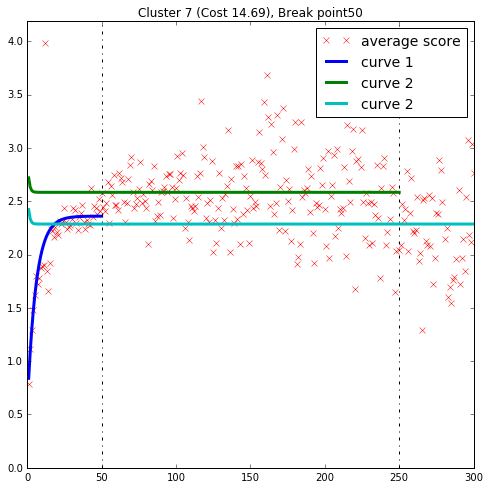

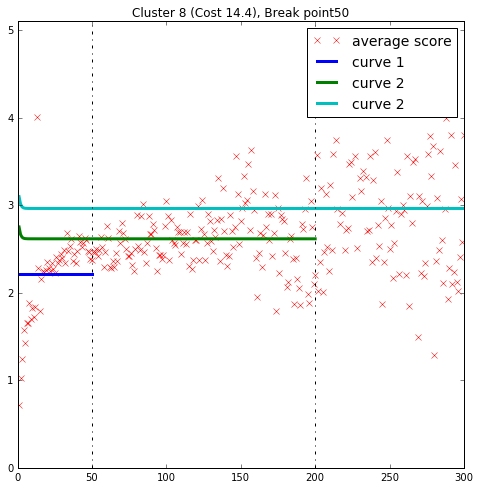

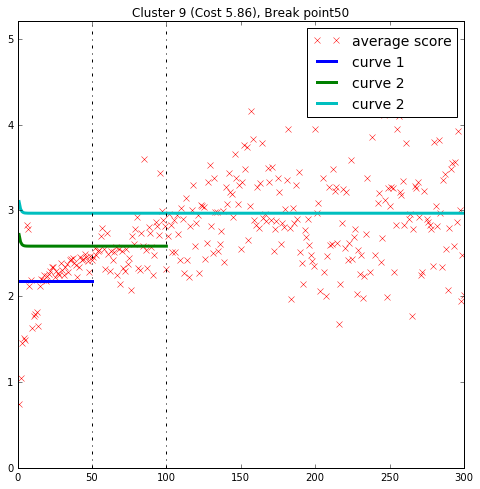

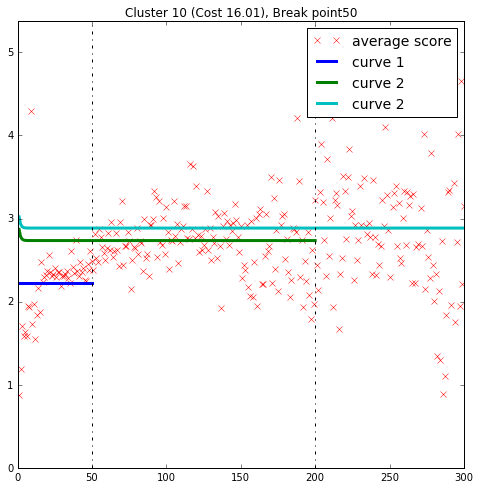

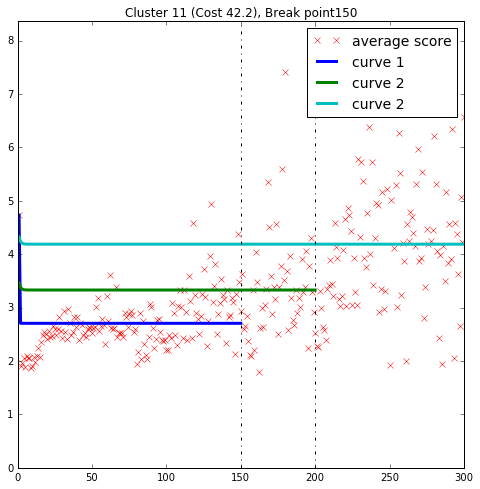

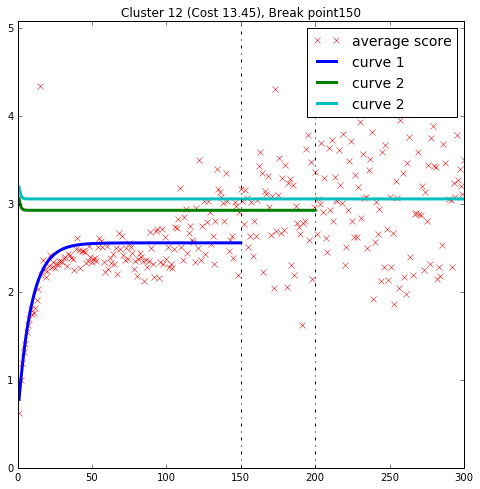

In [6]:
dcp.make_folders("../../Figs/curve_fitting/exponential4/three/")

seed = [1, 1, 1, 1]

for i in range(nClt): 
    print("cluster {0}:".format(i+1))
    p1, p2 = cv.multi_curveFitting_3(cv.exponential_least4, eval("avg{0}".format(i+1)), seed, min_range=50)

    x_range = np.linspace(1, 300, 300)
    x1 = x_range[:p1]
    x2 = x_range[p1:p2]
    x3 = x_range[p2:]

    true_y1 = eval("avg{0}".format(i+1))[:p1]
    true_y2 = eval("avg{0}".format(i+1))[p1:p2]
    true_y3 = eval("avg{0}".format(i+1))[p2:]

    lsq1 = least_squares(cv.exponential_least4, seed, args=(x1, true_y1))
    lsq2 = least_squares(cv.exponential_least4, seed, args=(x2, true_y2))
    lsq3 = least_squares(cv.exponential_least4, seed, args=(x3, true_y3))

    pred_y1 = cv.exponential_curve4(x_range[:p1], lsq1.x[0], lsq1.x[1], lsq1.x[2], lsq1.x[3])
    pred_y2 = cv.exponential_curve4(x_range[:p2], lsq2.x[0], lsq2.x[1], lsq2.x[2], lsq2.x[3])
    pred_y3 = cv.exponential_curve4(x_range, lsq3.x[0], lsq3.x[1], lsq3.x[2], lsq3.x[3])

    print(" - break point: {0}".format(p1))
    ## save figures
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(attempts300, eval("avg{0}".format(i+1)), 'rx', label='average score')
    ax.plot(x_range[:p1], pred_y1, 'b-', label='curve 1', linewidth=3)
    ax.plot(x_range[:p2], pred_y2, 'g-', label='curve 2', linewidth=3)
    ax.plot(x_range, pred_y3, 'c-', label='curve 2', linewidth=3)
    
    # break points
    ax.plot(np.ones(100)*p1, np.linspace(0, 10, 100), '-.k', linewidth=1)
    ax.plot(np.ones(100)*p2, np.linspace(0, 10, 100), '-.k', linewidth=1)
    
    ax.set_title("Cluster {0} (Cost {1}), Break point{2}"
                 .format(i, round(lsq1.cost+lsq2.cost, 2), p1) )
    ax.set_ylim([0, max( eval("avg{0}".format(i+1)) )+0.2])
    ax.legend(fontsize=14)
    fig.savefig("../../Figs/curve_fitting/exponential4/three/cluster{0}".format(i+1), dpi=100)
    # plt.show()